<a href="https://colab.research.google.com/github/Ala-Mohamed/Ml-/blob/main/Alaa_Mohamed_Assignment_3_Studens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

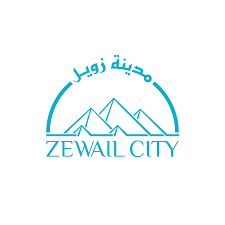

<h1 align="center">Zewail University of Science and Technology
</h1>

<h1 align="center">Biomedical Sciences_ Computational Biology and Genomics_BMS 474</h1>
<h1 align="center">FALL 2024	</h1>
<h1 align="center">Assignment 3 </h1>


#Initial Code Setup: Decision Tree

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from pprint import pprint

## Helper Functions

In [ ]:
# 1. Train-Test-Split
def train_test_split(df, test_size):

    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df


# 2. Distinguish categorical and continuous features
def determine_type_of_feature(df):

    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")

    return feature_types


# 3. Accuracy
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()

    return accuracy

##Desision Tree

In [ ]:
# 1.1 Data pure?
def check_purity(data):

    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False


# 1.2 Classify
def classify_data(data):

    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification


# 1.3 Potential splits?
def get_potential_splits(data, random_subspace):

    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label

    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)

    for column_index in column_indices:
        values = data[:, column_index]
        unique_values = np.unique(values)

        potential_splits[column_index] = unique_values

    return potential_splits


# 1.4 Lowest Overall Entropy?
def calculate_entropy(data):

    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy


def calculate_overall_entropy(data_below, data_above):

    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below)
                      + p_data_above * calculate_entropy(data_above))

    return overall_entropy


def determine_best_split(data, potential_splits):

    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value


# 1.5 Split data
def split_data(data, split_column, split_value):

    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]

    # feature is categorical
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]

    return data_below, data_above


# 2. Decision Tree Algorithm
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):

    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df


    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification


    # recursive part
    else:
        counter += 1

        # helper functions
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification

        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)

        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)

        # instantiate sub-tree
        sub_tree = {question: []}

        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)

        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree


# 3. Make predictions
# 3.1 One example
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)


# 3.2 All examples of the test data
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

#Task 1: Build your own Random Forest classifier from scratch

By following the steps below, you will gain a deeper understanding of how Random Forest works and how it combines multiple Decision Trees for improved performance.

Implement the following functions for Random Forest using the above Decision Tree implementation.

## Task 1.1: Resampling(train_df, n_bootstrap)
      
- It performs Resampling on a given training dataset train_df.

- Resampling is a statistical technique that involves random sampling with replacement.

- It performs random sampling with replacement to create a new dataset containing a subset of the original rows.
      
- This technique is commonly used in ensemble learning methods like Random Forest to create diverse subsets of data for training individual models.

In [ ]:
def Resampling(train_df, n_bootstrap):
    # Randomly select n_bootstrap rows from train_df with replacement
    bootstrap_indices = np.random.choice(train_df.index, size=n_bootstrap, replace=True)
    df_bootstrapped = train_df.loc[bootstrap_indices]
    return df_bootstrapped

## Task 1.2: random_forest_Combined(train_df, n_trees, n_bootstrap, n_features, dt_max_depth)

  - It implements the **random forest algorithm** from scratch.
  
  - It builds a random forest by repeatedly performing bootstrapping and constructing decision trees.
      
  - Each decision tree is built using a bootstrapped sample and a subset of randomly selected features.
      
  - The resulting random forest is a collection of decision trees that can be used for prediction or classification tasks.

In [ ]:
def random_forest_Combined(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        # 1. Resample the training data
        df_bootstrapped = Resampling(train_df, n_bootstrap)

        # 2. Train a decision tree using the bootstrapped data
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)

    return forest

## Task 1.3: random_forest_predictions(test_df, forest)
  - It is used to make predictions using a trained random forest on a given test dataset test_df
  
  - It iterates over each decision tree in the forest, makes predictions using the corresponding tree,and stores the predictions in a DataFrame.
  
  - The final predictions for the random forest are determined by taking the mode of the predictions across all decision trees.

In [ ]:
def random_forest_predictions(test_df, forest):
    df_predictions = pd.DataFrame()
    for tree in forest:
        column_name = 'tree_{}'.format(forest.index(tree))
        predictions = decision_tree_predictions(test_df, tree)
        df_predictions[column_name] = predictions

    # Random Forest Prediction
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    return random_forest_predictions

# Task 2:
Use your RF classifier you just built from scratch in classifying iris-data.Then, compare its accuracy to using decision tree.

## Task 2.1: Use your RF classifier you just built from scratch in classifying iris-data.

Using
seed =0,
n_trees=4,
n_bootstrap=800,
n_features=4,
dt_max_depth=4


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target)
X= pd.DataFrame(iris.data)
X.columns = ['sepal', 'sepal_width', 'petal', 'petal_width']
# Splitting the dataset into training and testing
random.seed(0)
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train_df = pd.DataFrame(X_train, columns=X.columns)
train_df['label'] = y_train

test_df = pd.DataFrame(X_test, columns=X.columns)
test_df['label'] = y_test

# Train the random forest (Ensure this function is correctly implemented)
forest = random_forest_Combined(train_df=train_df, n_trees=4, n_bootstrap=800, n_features=4, dt_max_depth=4)


# Make predictions on the test data
predictions = random_forest_predictions(test_df, forest)

# Calculate accuracy
accuracy = calculate_accuracy(test_df.label, predictions)

print(f"Random Forest Accuracy: {accuracy}")

Random Forest Accuracy: 0.9


## Task 2.2: lets compare it to using DT

In [ ]:
tree = decision_tree_algorithm(train_df, max_depth=4)
tree_predictions = decision_tree_predictions(test_df, tree)

# Calculate accuracy for the decision tree
tree_accuracy = calculate_accuracy(test_df['label'],tree_predictions)
print(f"Decision Tree Accuracy: {tree_accuracy}")
#it is higer that random forest accurcy

Decision Tree Accuracy: 1.0


#Task 3: Use the GSE45827 dataset for primary invasive breast cancer

you are  required to do the following using Scikit package :

1- Apply normalization step using standard scalar class (2 mark)

2- Perform PCA on the features (FV length= 50). (2 mark)

3- Use the  Random Forest classifier in the classification step (No. of decision trees is 20). (2 mark)

4- Split your data into training and testing (%80 training set-%20 testing) and report your accuracy (F score). (3 marks)

5- Now, implement K fold cross validation for evaluation (K = 5) and report the accuracy (F-score). (5 marks)

6- Discuss the results you got from 4 and 5. (2 mark)

7- Try different number of trees[50,60,70,80,90,100] in the random forest algorithm and decide which one is better(2 mark)


In [ ]:
!pip install GEOparse

In [ ]:
import GEOparse
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_score
data = GEOparse.get_GEO(geo="GSE45827")
print(data)

12-Dec-2024 17:00:07 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
12-Dec-2024 17:00:07 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE45nnn/GSE45827/soft/GSE45827_family.soft.gz to ./GSE45827_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE45nnn/GSE45827/soft/GSE45827_family.soft.gz to ./GSE45827_family.soft.gz
100%|██████████| 40.1M/40.1M [00:00<00:00, 57.1MB/s]
12-Dec-2024 17:00:08 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
12-Dec-2024 17:00:08 DEBUG downloader - Moving /tmp/tmpm0s9lcos to /content/GSE45827_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpm0s9lcos to /content/GSE45827_family.soft.gz
12-Dec-2024 17:00:08 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE45nnn/GSE45827/soft/GSE45827_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE45nnn/GSE45

<SERIES: GSE45827 - 155 SAMPLES, 1 d(s)>


In [ ]:
phenotype_data = data.phenotype_data
phenotype_data

label = phenotype_data['characteristics_ch1.1.tumor subtype']
label.isnull().sum()
expression_data = data.pivot_samples('VALUE').T
expression_data.describe()
expression_data.isnull().sum()

#
label.fillna(label.mode()[0], inplace=True)
label.isnull().sum()

x = expression_data.iloc[:, 1:]
y = label
x

ID_REF,1053_at,117_at,1294_at,1316_at,1405_i_at,1438_at,1487_at,1552256_a_at,1552257_a_at,1552258_at,...,87100_at,89476_r_at,90265_at,90610_at,91617_at,91684_g_at,91703_at,91816_f_at,91826_at,91952_at
name,,,,,,,,,,,,,,,,,,,,,
GSM1116084,8.36311,5.95426,6.02119,3.22997,10.82220,4.39698,6.65320,10.91320,10.07510,3.41108,...,3.90703,7.67662,8.58529,6.58532,6.47111,8.05685,5.51480,6.04568,5.90542,4.34839
GSM1116085,8.72194,7.02523,7.24581,3.29352,9.29455,6.68936,7.20820,9.32204,9.34476,3.33867,...,5.84253,7.32080,6.21915,6.81551,6.54900,6.62661,5.58320,5.67661,6.68275,4.94622
GSM1116086,7.78601,6.39671,6.85310,3.26204,9.45727,5.46440,6.68974,7.73131,8.43573,3.50054,...,4.32990,7.53787,7.86806,6.90606,6.32751,7.51148,5.85887,3.14257,7.77158,3.58973
GSM1116087,9.44537,4.56023,5.42786,3.34766,11.51270,5.29748,6.87276,10.39210,9.63893,3.37316,...,5.72709,7.86515,8.79839,7.09756,6.03216,7.38772,4.55774,3.04537,6.47312,4.55167
GSM1116088,7.71242,5.29008,7.51120,3.59086,8.83075,6.81821,6.45744,7.05836,9.37463,3.51171,...,4.66965,7.33174,7.01692,5.51992,6.09710,6.41229,5.34572,4.33680,8.48681,4.72397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1116234,6.88277,4.14597,6.37882,3.55309,6.36287,3.58838,6.44435,8.15810,6.76867,3.56286,...,7.35874,7.36935,7.40855,6.24758,5.05863,6.07391,4.92928,2.82099,7.16552,3.85854
GSM1116235,6.83700,6.10766,6.99674,3.23899,9.56499,5.11154,5.82317,7.34009,8.50502,4.07881,...,9.00438,7.59543,8.17949,7.14055,5.46896,6.57521,5.46086,3.74439,5.70158,4.25533
GSM1116236,7.29371,5.41169,8.37598,3.84879,8.11443,7.23567,6.02314,9.16813,8.68150,3.57036,...,5.50446,7.56045,8.15041,7.09543,6.06971,8.32561,4.97832,2.93524,7.88820,3.93143


In [ ]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# 2. PCA
#ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=4 with svd_solver='covariance_eigh'
# I made the PCA with 4 beacause it does not work with 50
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# 3. Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=20, random_state=0)

# 4. Train-test split and evaluation
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score on test set: {f1}")

# 5. K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)
f1_scores = cross_val_score(rf_classifier, X_pca, y, cv=kf, scoring='f1_weighted')
print("F1-scores for each fold",f1_scores)
print("Average F1-score across all folds:", np.mean(f1_scores))


# 6. Discussion
print("Compare the F1-score obtained from the train-test split and the average F1-score from 5-fold cross-validation.")
print("Cross-validation provides a more accute and better estimate of the model's performance on unseen data.")


# 7. Tuning the number of trees
trees_list = [50, 60, 70, 80, 90, 100]
best_f1 = 0
best_n_trees = 0
for n_trees in trees_list:
  rf_classifier = RandomForestClassifier(n_estimators=n_trees, random_state=0)
  f1_scores = cross_val_score(rf_classifier, X_pca, y, cv=kf, scoring='f1_weighted')
  avg_f1 = np.mean(f1_scores)
  if avg_f1 > best_f1:
    best_f1 = avg_f1
    best_n_trees = n_trees

print("\nBest number of trees:", best_n_trees, "\nBest Average F1-score:", best_f1)

F1-score on test set: 0.8404802328401649
F1-scores for each fold [0.83411535 0.89931574 0.86654016 0.77103542 0.86036866]
Average F1-score across all folds: 0.8462750658576086
Compare the F1-score obtained from the train-test split and the average F1-score from 5-fold cross-validation.
Cross-validation provides a more accute and better estimate of the model's performance on unseen data.

Best number of trees: 100 
Best Average F1-score: 0.876453641937513
